# **Mount Google Drive to the Colab**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install keras-vis

# **Import Relevent Libraries**

In [ ]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

# **Load Pretrained CNN model**

In [ ]:
IMAGES_DIR = '/content/drive/MyDrive/ML/Image caption generator Dataset/Image caption generator Dataset/Images'
CAPTIONS_FILE = '/content/drive/MyDrive/ML/Image caption generator Dataset/Image caption generator Dataset/captions.txt'

# Load the VGG16 model
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

553467096/553467096 [==============================] - 25s 0us/step


In [ ]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# **Extract and Save Image Features of Each image Using VGG16 Pretrined model**

In [ ]:
FEATURES_DIR = '/content/drive/MyDrive/ML/Image caption generator Dataset/Image caption generator Dataset/features'

# Creating the directory to store features
os.makedirs(FEATURES_DIR, exist_ok=True)


In [ ]:
# Extract features from images and save them
features = {}
for img_name in tqdm(os.listdir(IMAGES_DIR)):
    # Load the image from file
    img_path = os.path.join(IMAGES_DIR, img_name)
    image = load_img(img_path, target_size=(224, 224))
    # Convert image pixels to numpy array
    image = img_to_array(image)
    # Reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # Preprocess image for VGG
    image = preprocess_input(image)
    # Extract features
    feature = model.predict(image, verbose=0)
    # Get image ID
    image_id = img_name.split('.')[0]
    # Store feature
    features[image_id] = feature
    # Save feature to a numpy file
    feature_path = os.path.join(FEATURES_DIR, f'{image_id}.npy')
    np.save(feature_path, feature)

print(f"Features saved to {FEATURES_DIR}")

  0%|          | 0/8091 [00:00<?, ?it/s]

Features saved to /content/drive/MyDrive/ML/Image caption generator Dataset/Image caption generator Dataset/features


# **Load Features numpy array values to the features dictionary**

In [ ]:
# Load features from the numpy files
features = {}
feature_files = os.listdir(FEATURES_DIR)
if not feature_files:
    raise FileNotFoundError(f"No files found in the directory {FEATURES_DIR}.")

for feature_file in feature_files:
    if feature_file.endswith('.npy'):
        image_id = feature_file.split('.')[0]
        feature_path = os.path.join(FEATURES_DIR, feature_file)
        features[image_id] = np.load(feature_path)
    else:
        print(f"Skipping non-npy file: {feature_file}")

# Features are loaded and ready to use
print(f"Loaded {len(features)} features.")

Loaded 8091 features.


In [ ]:
# print the shape of the first loaded feature
sample_feature = next(iter(features.values()))
print(f"Sample feature shape: {sample_feature.shape}")

Sample feature shape: (1, 4096)


# **Load the Captions File**

In [ ]:
with open('/content/drive/MyDrive/ML/Image caption generator Dataset/Image caption generator Dataset/captions.txt', 'r') as f:
    next(f)
    captions_doc = f.read()

In [ ]:
import os
from tqdm import tqdm

CAPTIONS_FILE = '/content/drive/MyDrive/ML/Image caption generator Dataset/Image caption generator Dataset/captions.txt'
assert os.path.exists(CAPTIONS_FILE), "File not found!"

with open(CAPTIONS_FILE, 'r') as f:
    next(f)
    lines = f.readlines()

print(f"Total lines in the file: {len(lines)}")
print("First few lines of the file:")
for line in lines[:5]:
    print(line.strip())


Total lines in the file: 40455
First few lines of the file:
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .


# **Mapping the images with Corresponding Captions**

In [ ]:
# creating mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

# Verify the result
print(mapping)


100%|██████████| 40456/40456 [00:00<00:00, 653734.99it/s]

{'1000268201_693b08cb0e': ['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .'], '1001773457_577c3a7d70': ['A black dog and a spotted dog are fighting', 'A black dog and a tri-colored dog playing with each other on the road .', 'A black dog and a white dog with brown spots are staring at each other in the street .', 'Two dogs of different breeds looking at each other on the road .', 'Two dogs on pavement moving toward each other .'], '1002674143_1b742ab4b8': ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .', 'A little girl is sitting in front of a large painted rainbow .', 'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .', 'There is a girl with pigtails sitting

# **Clean Captions and Preprocessing**

In [ ]:
import re

In [ ]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
        # taking one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars...,
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = '<start> ' + " ".join([word for word in         caption.split() if len(word)>1]) + ' <end>'
            captions[i] = caption

In [ ]:
# before preprocess of text
mapping['1009434119_febe49276a']

['A black and white dog is running in a grassy garden surrounded by a white fence .',
 'A black and white dog is running through the grass .',
 'A Boston terrier is running in the grass .',
 'A Boston Terrier is running on lush green grass in front of a white fence .',
 'A dog runs on the green grass near a wooden fence .']

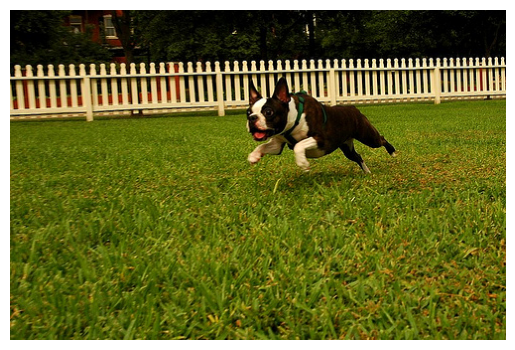

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_filename = '/content/drive/MyDrive/ML/Image caption generator Dataset/Image caption generator Dataset/Images/1009434119_febe49276a.jpg'

# Read and display the image
img = mpimg.imread(image_filename)
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
# preprocess the text
clean(mapping)

In [ ]:
# after preprocess of text
mapping['1009434119_febe49276a']

['<start> black and white dog is running in grassy garden surrounded by white fence <end>',
 '<start> black and white dog is running through the grass <end>',
 '<start> boston terrier is running in the grass <end>',
 '<start> boston terrier is running on lush green grass in front of white fence <end>',
 '<start> dog runs on the green grass near wooden fence <end>']

In [ ]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

**Tokenization of the Captions and initiate Vocab size,max length**

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
vocab_size

8483

In [ ]:
# maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

# **Split the Data in to Train and Test**

In [ ]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [ ]:
train_features = {}
for i in tqdm(train):
    train_features[i] = features[i]

100%|██████████| 7281/7281 [00:00<00:00, 754005.42it/s]


In [ ]:
test_features = {}
for i in tqdm(test):
    test_features[i] = features[i]

100%|██████████| 810/810 [00:00<00:00, 630663.86it/s]


In [ ]:
import random
# Setting random seed for reproducibility of results
random.seed('1000')
# Shuffle train data

random.shuffle(train)
train_captions = {_id: mapping[_id] for _id in train}

test_captions = {_id: mapping[_id] for _id in test}


# **Model 1 Define**

In [ ]:
# define the captioning model1
def RNN_model_UniDirectLSTM(vocab_size, max_length, embedding_size, units, input_size):
    # feature extractor model
    imageInput = Input(shape=(input_size,))
    flattenImg = Dropout(0.4)(imageInput)
    fullyConnected = Dense(embedding_size, activation='relu')(flattenImg)
    # sequence model
    captionInput = Input(shape=(max_length,))
    sequence1 = Embedding(vocab_size, embedding_size, mask_zero=True)(captionInput)
    sequence2 = Dropout(0.3)(sequence1)
    sequence3 = LSTM(units)(sequence2)
    # decoder model
    decoder1 = add([fullyConnected, sequence3])
    decoder2 = Dense(units, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # tie it together [image, seq] [word]
    model = Model(inputs=[imageInput, captionInput], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # summarize model
    print(model.summary())
    return model


In [ ]:
# define the model
embedding_size = 256
units = 256
input_size = 4096
finalmodel = RNN_model_UniDirectLSTM(vocab_size, max_length, embedding_size, units, input_size)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 35)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 4096)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 35, 256)              2171648   ['input_3[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 4096)                 0         ['input_2[0][0]']             
                                                                                            

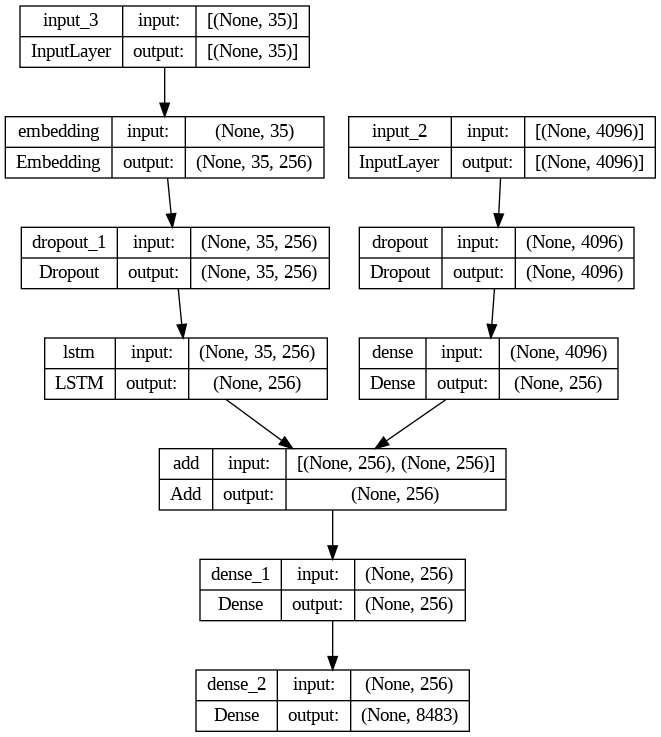

In [ ]:
plot_model(finalmodel, show_shapes=True)

# **Data Preperation For Model Training**

In [ ]:
# Create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, captions_list, image):
    # In1 : input for image features
    # In2 : input for text features
    # Out  : output word
    In1, In2, Out = list(), list(), list()
    vocab_size = len(tokenizer.word_index) + 1
    # loop each caption for the image
    for caption in captions_list:
        # Encode the sequence
        seq = tokenizer.texts_to_sequences([caption])[0]
        # Split one sequence into multiple In1,Out pairs
        for i in range(1, len(seq)):
            # Split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # Pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # Encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # Store data
            In1.append(image)
            In2.append(in_seq)
            Out.append(out_seq)
    return In1, In2, Out


In [ ]:
# Data generator function  to be used in a call to model.fit()
def data_process(images, captions, tokenizer, max_length, batch_size, random_seed):
    # Setting random seed for reproducibility of results
    random.seed(random_seed)
    # Image ids
    image_ids = list(captions.keys())
    _count=0
    while True:
        if _count >= len(image_ids):
            # restart
            _count = 0
        # Batch list to store data
        input_img_batch, input_sequence_batch, output_word_batch = list(), list(), list()
        for i in range(_count, min(len(image_ids), _count+batch_size)):

            image_id = image_ids[i]

            image = images[image_id][0]
            # Retrieve the captions list
            captions_list = captions[image_id]
            # Shuffle captions list
            random.shuffle(captions_list)
            input_img, input_sequence, output_word = create_sequences(tokenizer, max_length, captions_list, image)
            # Add to batch
            for j in range(len(input_img)):
                input_img_batch.append(input_img[j])
                input_sequence_batch.append(input_sequence[j])
                output_word_batch.append(output_word[j])
        _count = _count + batch_size
        yield ([np.array(input_img_batch), np.array(input_sequence_batch)], np.array(output_word_batch))


In [ ]:
# define parameters
num_of_epochs = 10
batch_size = 32
train_length = len(train)
val_length = len(test)
steps_train = train_length // batch_size
if train_length % batch_size != 0:
    steps_train = steps_train+1
steps_val = val_length // batch_size
if val_length % batch_size != 0:
    steps_val = steps_val+1


In [ ]:
#  train data generator
generator_train = data_process(train_features, train_captions, tokenizer, max_length, batch_size, random_seed='1000')
# test data generator
generator_val = data_process(test_features, test_captions, tokenizer, max_length, batch_size, random_seed='1000')

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
# define checkpoint callback
filepath = '/content/drive/MyDrive/ML/RNN_model_UniDirectLSTM_vgg16.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# define early stopping callback
early = EarlyStopping(patience=5, verbose=1)


**Model 1 Training**

In [ ]:
# Fit
history = finalmodel.fit(generator_train,
            epochs=num_of_epochs,
            steps_per_epoch=steps_train,
            validation_data=generator_val,
            validation_steps=steps_val,
            callbacks=[checkpoint, early],
            verbose=1)


Epoch 1/10
228/228 [==============================] - ETA: 0s - loss: 5.2178
Epoch 1: val_loss improved from inf to 4.36584, saving model to /content/drive/MyDrive/ML/RNN_model_UniDirectLSTM_vgg16.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


228/228 [==============================] - 114s 460ms/step - loss: 5.2178 - val_loss: 4.3658
Epoch 2/10
228/228 [==============================] - ETA: 0s - loss: 3.9949
Epoch 2: val_loss improved from 4.36584 to 3.93010, saving model to /content/drive/MyDrive/ML/RNN_model_UniDirectLSTM_vgg16.h5
228/228 [==============================] - 69s 303ms/step - loss: 3.9949 - val_loss: 3.9301
Epoch 3/10
228/228 [==============================] - ETA: 0s - loss: 3.5615
Epoch 3: val_loss improved from 3.93010 to 3.82360, saving model to /content/drive/MyDrive/ML/RNN_model_UniDirectLSTM_vgg16.h5
228/228 [==============================] - 66s 287ms/step - loss: 3.5615 - val_loss: 3.8236
Epoch 4/10
228/228 [==============================] - ETA: 0s - loss: 3.2901
Epoch 4: val_loss improved from 3.82360 to 3.81581, saving model to /content/drive/MyDrive/ML/RNN_model_UniDirectLSTM_vgg16.h5
228/228 [==============================] - 65s 285ms/step - loss: 3.2901 - val_loss: 3.8158
Epoch 5/10
228/228 

**Plot the Model 1 Performance**

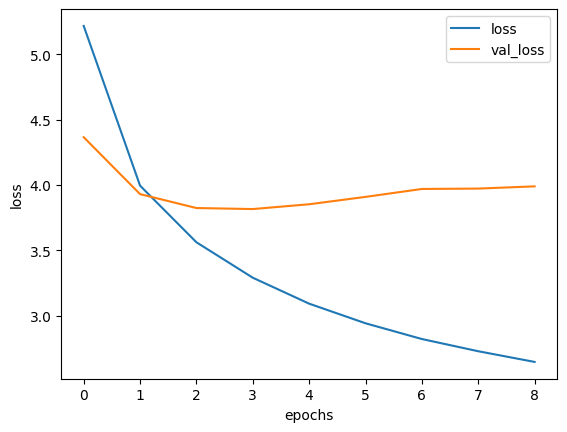

In [ ]:
# using rnn_model_1_vgg16
import matplotlib.pyplot as plt

for label in ["loss","val_loss"]:
    plt.plot(history.history[label],label=label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.savefig('/content/drive/MyDrive/ML/Image caption generator Dataset/Image caption generator Dataset')
plt.show()


In [ ]:
from numpy import argmax

# **Functions for Caption Prediction**

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
             return word
    return None

In [ ]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = '<start>'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if reach end tag
        if word == 'end':
            break
    return in_text

In [ ]:
def cleanCap(in_text):
    words = in_text.split()
    if len(words) > 2:
        return ' '.join(words[1:-1])
    else:
        return ''

# **Evaluate The Model 1**

In [ ]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

In [ ]:
def calculate_scores(actual, predicted):
    # calculate BLEU score
    smooth = SmoothingFunction().method4
    bleu1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0), smoothing_function=smooth)*100
    bleu2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth)*100

    print('BLEU-1: %f' % bleu1)
    print('BLEU-2: %f' % bleu2)


In [ ]:
# evaluate the model
def evaluate_model(model, descriptions, features, tokenizer, max_length):
    actual, predicted = list(), list()
    # step over the whole set
    for key, desc_list in tqdm(descriptions.items(), position=0, leave=True):
        # generate description
        yhat = predict_caption(model, features[key], tokenizer, max_length)
        # store actual and predicted
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
    print('Blue Score:')
    calculate_scores(actual, predicted)


In [ ]:
from keras.models import Model

In [ ]:
from keras.models import load_model

In [ ]:
# load the model
filepath = '/content/drive/MyDrive/ML/RNN_model_UniDirectLSTM_vgg16.h5'
Caption_Generator_Model = load_model(filepath)

In [ ]:
# evaluate model
evaluate_model(Caption_Generator_Model, test_captions, test_features, tokenizer, max_length)

100%|██████████| 810/810 [10:45<00:00,  1.25it/s]


Blue Score:
BLEU-1: 45.085770
BLEU-2: 27.208923


# **Caption Prediction For Model 1**

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def captionGenerator(image_name):
    # load the image
    image_id = image_name.split('.')[0]
    img_path =  os.path.join(IMAGES_DIR, image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(finalmodel,  features[image_id],tokenizer , max_length)
    y_pred = cleanCap(y_pred)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

**Generate Caption For Images which are in Test Data set**

---------------------Actual---------------------
<start> black dog and spotted dog are fighting <end>
<start> two dogs on pavement moving toward each other <end>
<start> black dog and tri-colored dog playing with each other on the road <end>
<start> two dogs of different breeds looking at each other on the road <end>
<start> black dog and white dog with brown spots are staring at each other in the street <end>
--------------------Predicted--------------------
two dogs are playing with red toy in the grass


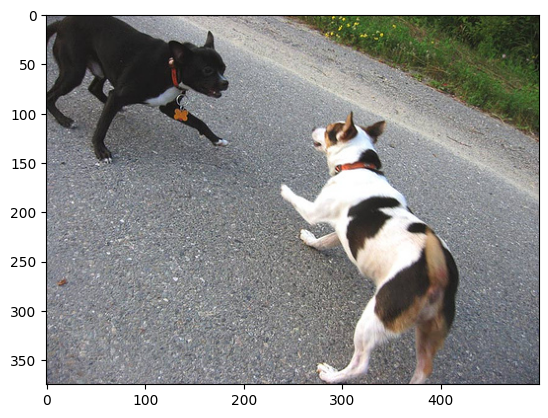

In [ ]:
captionGenerator("1001773457_577c3a7d70.jpg")

---------------------Actual---------------------
<start> little girl is sitting in front of large painted rainbow <end>
<start> there is girl with pigtails sitting in front of rainbow painting <end>
<start> little girl covered in paint sits in front of painted rainbow with her hands in bowl <end>
<start> small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it <end>
<start> young girl with pigtails painting outside in the grass <end>
--------------------Predicted--------------------
child in red shirt is sitting in the middle of the middle of the middle of the middle of the road


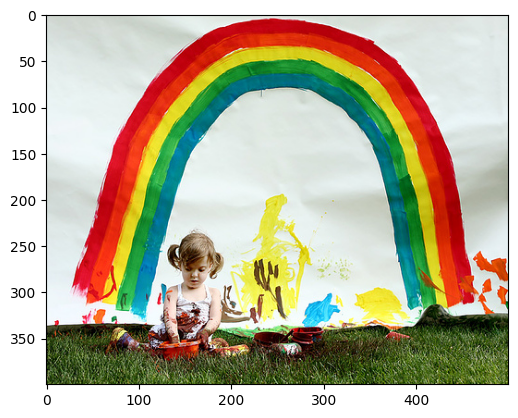

In [ ]:
captionGenerator("1002674143_1b742ab4b8.jpg")

---------------------Actual---------------------
<start> lady holds little girl who is trying to catch bubbles <end>
<start> woman with holding young girl playing with bubbles at picnic <end>
<start> "a young woman in blue shirt stands holding young girl in denim dress ." <end>
<start> there is woman holding her baby daughter while the daughter claps <end>
<start> woman is holding little girl who is trying to catch bubbles <end>
--------------------Predicted--------------------
girl in red shirt and white shirt is standing in front of white fence


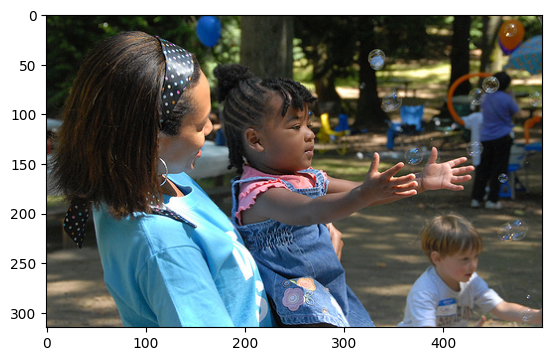

In [ ]:
captionGenerator("1237985362_dbafc59280.jpg")

---------------------Actual---------------------
<start> boy jumped up from the green bed <end>
<start> small child is jumping on bed <end>
<start> the boy in blue shorts is bouncing on the bed <end>
<start> boy is jumping on bed <end>
<start> boy jumps from one bed to another <end>
--------------------Predicted--------------------
young boy jumping on bed


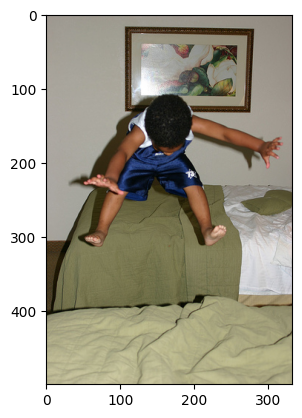

In [ ]:
captionGenerator("1131932671_c8d17751b3.jpg")

---------------------Actual---------------------
<start> an elderly man is smiling while sitting in front of row of soda cans <end>
<start> man wearing glasses with aluminum cans lined up in front of him <end>
<start> man is sitting at an outside bar near many soda and beer cans <end>
<start> vendor selling drinks in stall <end>
<start> korean man sells soda <end>
--------------------Predicted--------------------
korean man sells soda cans


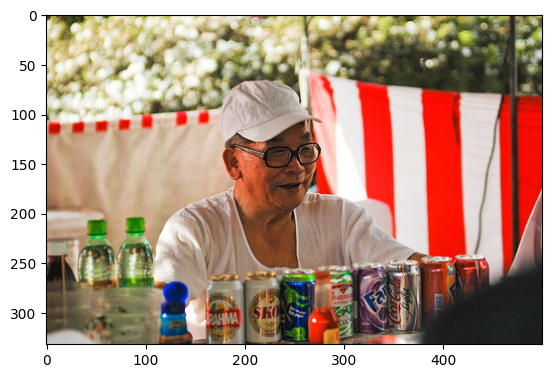

In [ ]:
captionGenerator("1234817607_924893f6e1.jpg")

**Generate captions for images imported from outside of the dataset**

In [ ]:
def preprocess_image(image_path):
    # Load the image with the required target size
    image = load_img(image_path, target_size=(224, 224))
    # Convert the image to an array
    image = img_to_array(image)
    # Reshape data for the model
    image = np.expand_dims(image, axis=0)
    # Prepare the image for the InceptionV3 model
    image = preprocess_input(image)
    return image

In [ ]:
def extract_features(image_path, model):
    image = preprocess_image(image_path)
    features = model.predict(image, verbose=0)
    return features

In [ ]:
# Path to the image
image_path = '/content/drive/MyDrive/family-creating-digital-content.jpg'

# Extract features
photo = extract_features(image_path, model)

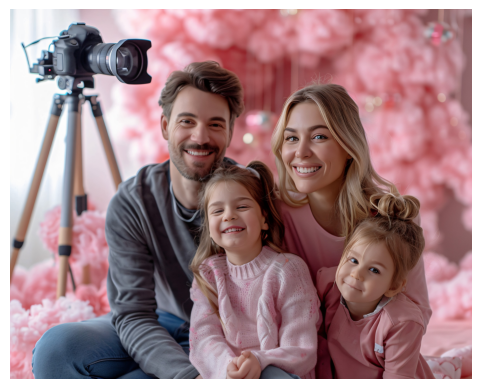

In [ ]:
# Read and display the image
img = mpimg.imread(image_path)
imgplot = plt.imshow(img)
plt.axis('off')  # Turn off the axis
plt.show()

In [ ]:
caption = predict_caption(Caption_Generator_Model,photo, tokenizer , max_length=35)

In [ ]:
clean_caption = cleanCap(caption)
print('Generated Caption:', clean_caption)

Generated Caption: two girls dressed in red costume are playing in the air


# **Model 2 Define**

In [ ]:
from keras.layers import Input, Dense, Embedding, LSTM, RepeatVector, TimeDistributed, Bidirectional, concatenate

In [ ]:
# define the captioning model2
def RNN_model_Bidirect(vocab_size, max_length, embedding_size, units, input_size):
    image_input = Input(shape=(input_size,))
    image_model_1 = Dense(embedding_size, activation='relu')(image_input)
    image_model = RepeatVector(max_length)(image_model_1)

    caption_input = Input(shape=(max_length,))
    # mask_zero: We zero pad inputs to the same length, the zero mask ignores those inputs
    caption_model_1 = Embedding(vocab_size, embedding_size, mask_zero=True)(caption_input)
    # Since we are going to predict the next word using the previous words, we have to set return_sequences = True.
    caption_model_2 = LSTM(units, return_sequences=True)(caption_model_1)
    caption_model = TimeDistributed(Dense(embedding_size))(caption_model_2)

    # Merging the models and creating a softmax classifier
    final_model_1 = concatenate([image_model, caption_model])
    final_model_2 = Bidirectional(LSTM(units, return_sequences=False))(final_model_1)
    final_model_3 = Dense(units, activation='relu')(final_model_2)
    final_model = Dense(vocab_size, activation='softmax')(final_model_3)

    model = Model(inputs=[image_input, caption_input], outputs=final_model)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # summarize model
    print(model.summary())
    return model


In [ ]:
# define the model
embedding_size = 256
units = 256
input_size = 4096
finalmodel2 = RNN_model_Bidirect(vocab_size, max_length, embedding_size, units, input_size)


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 35)]                 0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 4096)]               0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 35, 256)              2171648   ['input_5[0][0]']             
                                                                                                  
 dense_3 (Dense)             (None, 256)                  1048832   ['input_4[0][0]']             
                                                                                            

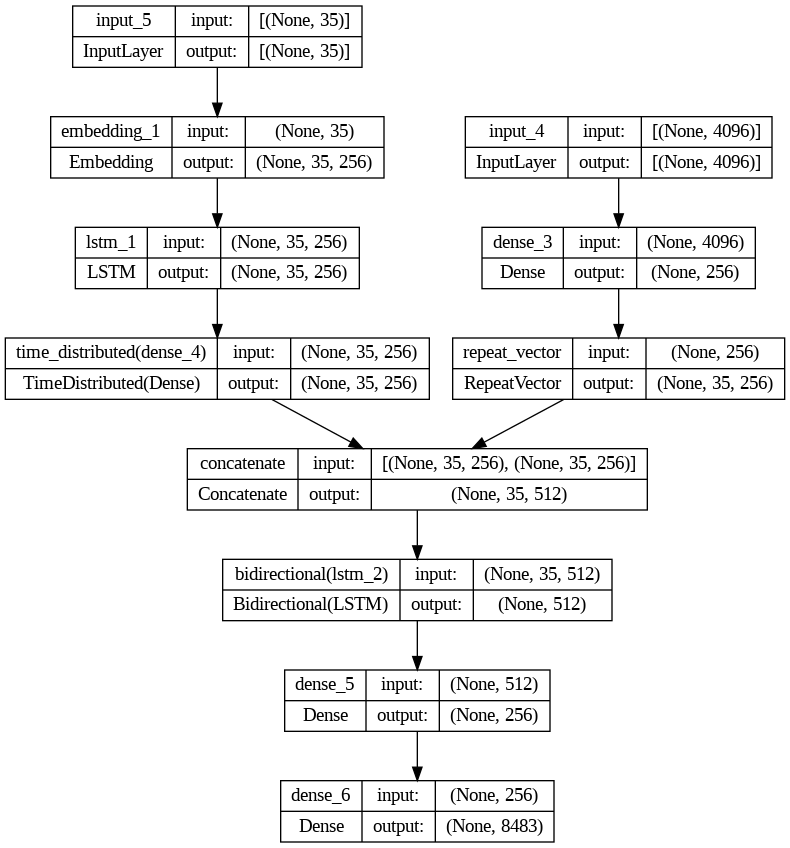

In [ ]:
plot_model(finalmodel2, show_shapes=True)

# **Model 2 Training**

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
# define checkpoint callback
filepath = '/content/drive/MyDrive/ML/RNN_model_bidirect_vgg16.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# define early stopping callback
early = EarlyStopping(patience=5, verbose=1)


In [ ]:
# Fit
history = finalmodel2.fit(generator_train,
            epochs=num_of_epochs,
            steps_per_epoch=steps_train,
            validation_data=generator_val,
            validation_steps=steps_val,
            callbacks=[checkpoint, early],
            verbose=1)


Epoch 1/10
228/228 [==============================] - ETA: 0s - loss: 5.8458
Epoch 1: val_loss improved from inf to 5.43252, saving model to /content/drive/MyDrive/ML/RNN_model_bidirect_vgg16.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


228/228 [==============================] - 181s 733ms/step - loss: 5.8458 - val_loss: 5.4325
Epoch 2/10
228/228 [==============================] - ETA: 0s - loss: 5.1110
Epoch 2: val_loss improved from 5.43252 to 4.69515, saving model to /content/drive/MyDrive/ML/RNN_model_bidirect_vgg16.h5
228/228 [==============================] - 136s 598ms/step - loss: 5.1110 - val_loss: 4.6951
Epoch 3/10
228/228 [==============================] - ETA: 0s - loss: 4.4212
Epoch 3: val_loss improved from 4.69515 to 4.18794, saving model to /content/drive/MyDrive/ML/RNN_model_bidirect_vgg16.h5
228/228 [==============================] - 130s 572ms/step - loss: 4.4212 - val_loss: 4.1879
Epoch 4/10
228/228 [==============================] - ETA: 0s - loss: 3.9384
Epoch 4: val_loss improved from 4.18794 to 3.94498, saving model to /content/drive/MyDrive/ML/RNN_model_bidirect_vgg16.h5
228/228 [==============================] - 132s 580ms/step - loss: 3.9384 - val_loss: 3.9450
Epoch 5/10
228/228 [===========

**Plot the Model 2 Performance**

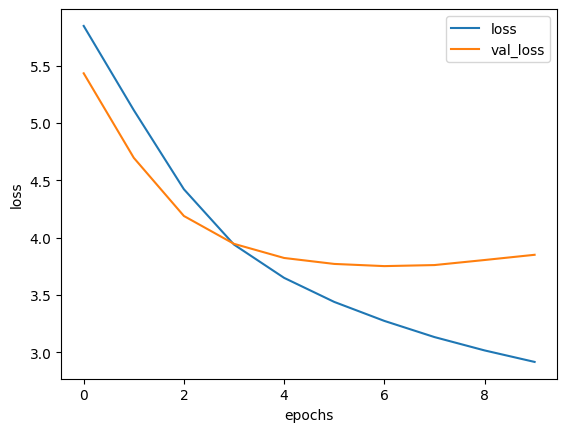

In [ ]:
# using rnn_2 and vgg16
import matplotlib.pyplot as plt

for label in ["loss","val_loss"]:
    plt.plot(history.history[label],label=label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.savefig('/content/drive/MyDrive/ML/Image caption generator Dataset/Image caption generator Dataset')
plt.show()


In [ ]:
filepath = '/content/drive/MyDrive/ML/RNN_model_bidirect_vgg16.h5'
Caption_Generator_Model2 = load_model(filepath)

# **Evaluate The Model 2**

In [ ]:
evaluate_model(Caption_Generator_Model2, test_captions, test_features, tokenizer, max_length)

100%|██████████| 810/810 [13:03<00:00,  1.03it/s]


Blue Score:
BLEU-1: 47.245241
BLEU-2: 28.995790


# **Caption Prediction For Model 2**

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def captionGenerator2(image_name):
    # load the image
    #image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path =  os.path.join(IMAGES_DIR, image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(Caption_Generator_Model2,  features[image_id],tokenizer , max_length)
    y_pred = cleanCap(y_pred)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

**Generate Caption For Images which are in Test Data set**

---------------------Actual---------------------
<start> two dogs on pavement moving toward each other <end>
<start> two dogs of different breeds looking at each other on the road <end>
<start> black dog and spotted dog are fighting <end>
<start> black dog and white dog with brown spots are staring at each other in the street <end>
<start> black dog and tri-colored dog playing with each other on the road <end>
--------------------Predicted--------------------
two dogs are playing in the grass


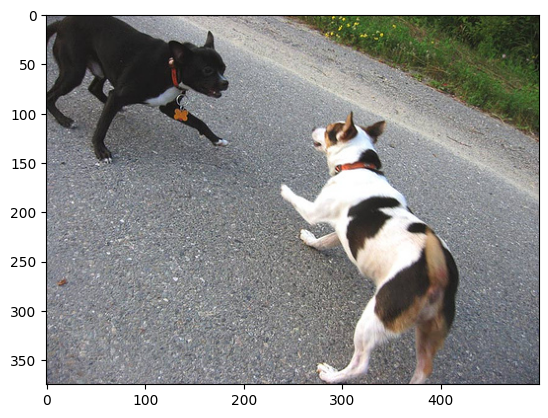

In [ ]:
captionGenerator2("1001773457_577c3a7d70.jpg")

---------------------Actual---------------------
<start> young girl with pigtails painting outside in the grass <end>
<start> there is girl with pigtails sitting in front of rainbow painting <end>
<start> small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it <end>
<start> little girl is sitting in front of large painted rainbow <end>
<start> little girl covered in paint sits in front of painted rainbow with her hands in bowl <end>
--------------------Predicted--------------------
two children are standing in front of tree


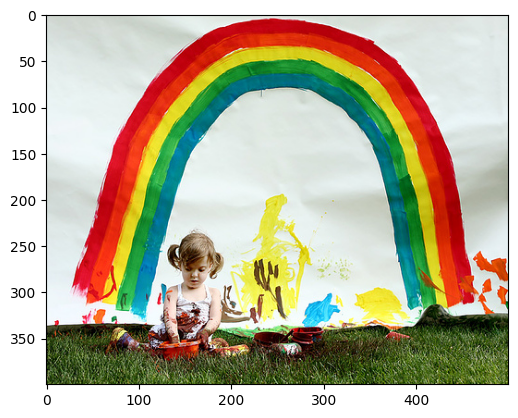

In [ ]:
captionGenerator2("1002674143_1b742ab4b8.jpg")

---------------------Actual---------------------
<start> woman is holding little girl who is trying to catch bubbles <end>
<start> lady holds little girl who is trying to catch bubbles <end>
<start> woman with holding young girl playing with bubbles at picnic <end>
<start> there is woman holding her baby daughter while the daughter claps <end>
<start> "a young woman in blue shirt stands holding young girl in denim dress ." <end>
--------------------Predicted--------------------
girl in pink shirt is standing in the grass


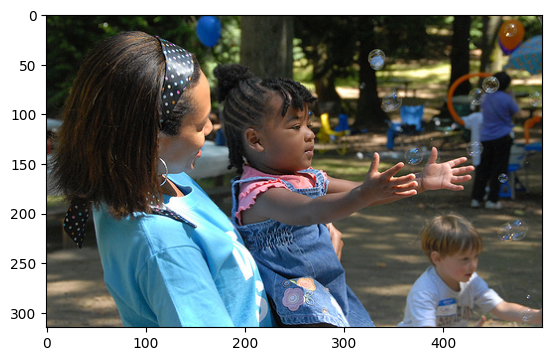

In [ ]:
captionGenerator2("1237985362_dbafc59280.jpg")

---------------------Actual---------------------
<start> boy jumps from one bed to another <end>
<start> boy jumped up from the green bed <end>
<start> small child is jumping on bed <end>
<start> the boy in blue shorts is bouncing on the bed <end>
<start> boy is jumping on bed <end>
--------------------Predicted--------------------
the boy is jumping on the slide


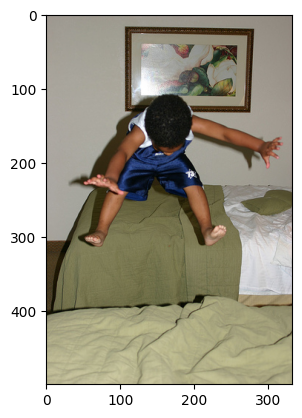

In [ ]:
captionGenerator2("1131932671_c8d17751b3.jpg")

---------------------Actual---------------------
<start> vendor selling drinks in stall <end>
<start> man wearing glasses with aluminum cans lined up in front of him <end>
<start> korean man sells soda <end>
<start> an elderly man is smiling while sitting in front of row of soda cans <end>
<start> man is sitting at an outside bar near many soda and beer cans <end>
--------------------Predicted--------------------
man in black and white shirt is sitting in front of the building


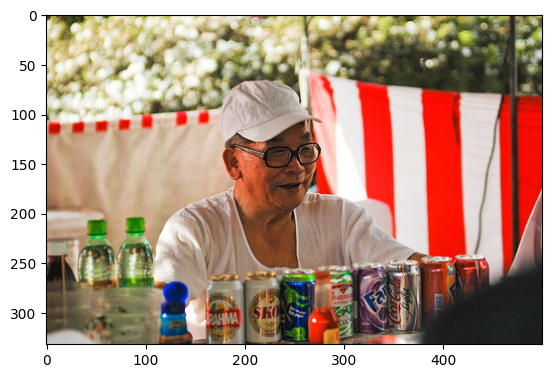

In [ ]:
captionGenerator2("1234817607_924893f6e1.jpg")

**Generate captions for images imported from outside of the dataset**

In [ ]:
photo2 = extract_features(image_path, model)

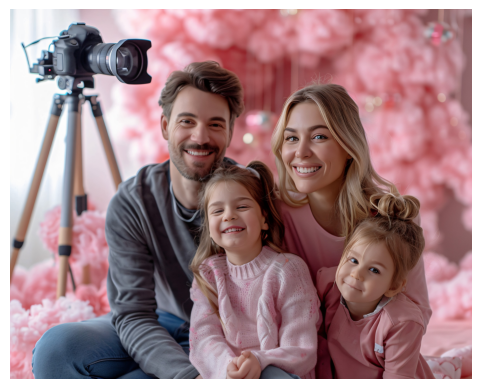

In [ ]:
# Read and display the image
img = mpimg.imread(image_path)
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
caption2 = predict_caption(Caption_Generator_Model2, photo, tokenizer,  max_length=35)

In [ ]:
clean_caption2 = cleanCap(caption2)
print('Generated Caption:', clean_caption2)

Generated Caption: two women in costume are smiling
